Данный блокнот содержит выжимку из рабочего блокнота. Предоставленный код является работоспособным, единственное, что модель была обучена в другом блокноте, но с применением этого же кода. Поэтому не стоит удивляться выводу после блоков. Обучение происходило с помощью GPU, поэтому не рекомендуется пытаться обучать модель, если у вас активен CPU.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os
import io
import sys

In [2]:
print(f"Python version: {sys.version}")
print(f"TensorFlow version: {tf.__version__}")

Python version: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.10.0


Датасет был собран из различных датасетов. Структура датасета представляет собой изображения в форматах JPG, JPEG и PNG, расположенные в разных папках. В следующем блоке выполняется обход папок и загрузка датасета в оперативную память.

In [3]:
root_dir = r'C:\Users\bffus\OneDrive\Рабочий стол\MAIN'

pixels = []
labels = []

target_size = (96, 96)

for label in os.listdir(root_dir):
    sub_dir = os.path.join(root_dir, label)
    
   
    if os.path.isdir(sub_dir):
        for file_name in os.listdir(sub_dir):
            file_path = os.path.join(sub_dir, file_name)
            
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                with Image.open(file_path) as img:
                    img = img.resize(target_size).convert('L')
                    img_pixels = np.array(img)
                    pixels.append(img_pixels)
                    

                    t = -1
                    if label == 'anger':
                        t = 0
                    elif label == 'disgust':
                        t = 1
                    elif label == 'fear':
                        t = 2
                    elif label == 'happiness':
                        t = 3
                    elif label == 'neutrality':
                        t = 4
                    elif label == 'sadness':
                        t = 5
                    elif label == 'surprise':
                        t = 6
                    labels.append(t)


pixels = np.array(pixels)
pixels = np.expand_dims(pixels, axis=3)


labels = np.array(labels)


pixels = pixels / 255
labels = keras.utils.to_categorical(labels, 7)


print(pixels.shape)
print(labels.shape)

(35759, 96, 96, 1)
(35759, 7)


После загрузки и нормализации данные разделены на тренировочный и валидационный наборы. Валидационные данные необходимы для оценки предсказательной силы модели в процессе обучения.

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(pixels, labels,
                                                    shuffle=True, stratify=labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

del pixels
del labels

Архитектура модели была подобрана по аналогии с известной архитектурой для классификации графических объектов - VGG19. Возможно, выразительная сила данной архитектуры превышает необходимую, но я исходил из соображений о том, чтобы был определенный запас.

In [5]:
model = keras.Sequential([
    
    Conv2D(64, (3,3), padding="same", kernel_initializer='he_normal', input_shape=(96, 96, 1)),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    Conv2D(64, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    
    MaxPooling2D((2,2), strides=2),

    Conv2D(128, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    Conv2D(128, (3,3), padding="same",  kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),

    MaxPooling2D((2,2), strides=2),
    
    Conv2D(256, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    Conv2D(256, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    Conv2D(256, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    
    MaxPooling2D((2,2), strides=2),
    
    Conv2D(512, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    Conv2D(512, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    Conv2D(512, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),  
    
    MaxPooling2D((2,2), strides=2),
    
    Conv2D(1024, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    Conv2D(1024, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),
    Conv2D(1024, (3,3), padding="same", kernel_initializer='he_normal'),
    LeakyReLU(alpha=0.075),
    BatchNormalization(),  
    
    GlobalAveragePooling2D(),
    
    Flatten(),
    Dense(256),
    LeakyReLU(alpha=0.075),
    Dropout(0.33),
    
    Dense(128),
    LeakyReLU(alpha=0.075),
    Dropout(0.33),
      
    Dense(7, activation='softmax')
])


early_stopping - прекращает обучение, когда оно становится неэффективным.
train_datagen - позволяет модифицировать данные (вращать, масштабировать, смещать) в процессе обучения, чтобы вынуждать модель обобщать данные.
train_datagen.fit(X_train) - подготавливает генератор данных для последующего использования при обучении модели, применяя необходимые преобразования к тренировочным изображениям.

In [6]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)


callbacks = [
    early_stopping,
]


train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

В качестве оптимизатора я применяю стохастический градиентный спуск с моментами Нестерова, функцию потерь - категориальную кросс-энтропию (наиболее подходящую для задач графической классификации, где категорий больше 2), и метрику - точность предсказания.

In [7]:
batch_size = 64
epochs = 15

sgd = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.75, nesterov=True )

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Непосредственное обучение модели с использованием ранее подготовленного.

In [8]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=False
)

Epoch 1/15
 10/503 [..............................] - ETA: 2:16 - loss: 2.0626 - accuracy: 0.1063

KeyboardInterrupt: 

Команды для загрузки, выгрузки модели по указанному пути.

In [9]:
#model = load_model('path')
#model.save('path')

Оценка валидационными данными.

In [9]:
model.evaluate(X_valid, y_valid)

 49/112 [============>.................] - ETA: 3s - loss: 2.0053 - accuracy: 0.0874

KeyboardInterrupt: 

Непосредственная проба.

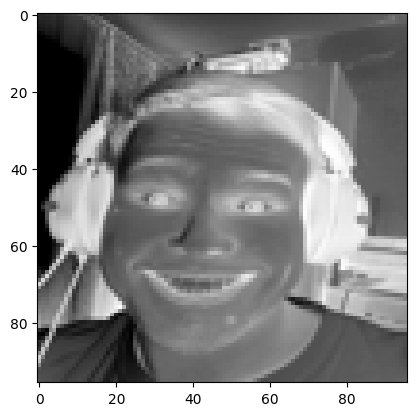

1/1 [==============================] - 0s 33ms/step
2-fear


In [13]:
with open("1.jpg", "rb") as f:
    image_data = f.read()

def preprocess_image(image_data):
    image = Image.open(io.BytesIO(image_data))
    image = image.convert('L')
    image = image.resize((96, 96))

    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()
    
    image_array = np.array(image) / 255.0
    
    image_array = np.expand_dims(image_array, axis=-1)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array



prep_im = preprocess_image(image_data)
res = model.predict(prep_im)
t = np.argmax(res)

print(t, end='-')

if t == 0:
    print('angry')
elif t == 1:
    print('disgust')
elif t == 2:
    print('fear')
elif t == 3:
    print('happy')
elif t == 4:
    print('neutral')
elif t == 5:
    print('sad')
elif t == 6:
    print('surprise')



